# Extract cell level results (modified for IPQDA)

In [1]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


#### (IPQDA: Change values here)

In [2]:
# hard-code the paths of our input and output directories
path_input = "big-fish-IPQDA/data/input/TSA"

path_output = "big-fish-IPQDA/data/output/TSA"

In this notebook, we show examples to **extract results at the cell level**. We combine the results of the previous notebook. As a reminder, segmentation is performed in 2D, but detection can be performed in 2D or 3D. Several steps are presented:
- Presentation of the different formats expected for the segmentation and detection results.
- Detection and filtering of the transcription sites.
- Extraction of the FoV results at the cell levels.
- Cell plots.

#### (IPQDA: Change values here)

In [3]:
#Nucleus channel (DAPI)
path = os.path.join(path_input, "TSA_615_dapi_fov_1.tif")

nuc = stack.read_image(path)
nuc_mip = stack.maximum_projection(nuc)
print("smfish channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype), "\n")

#FISH channel
path = os.path.join(path_input, "TSA_615_smfish_fov_1.tif")

rna = stack.read_image(path)
rna_mip = stack.maximum_projection(rna)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)

smfish channel
 shape: (15, 512, 512)
 dtype: uint16 

smfish channel
 shape: (15, 512, 512)
 dtype: uint16


## Read segmentation and detection results

The input files need to follow a specific format:
- **Segmented cells** can be saved in a tif file. It should be a 2D array with integers (np.uint8, np.uint16 or np.int64). This array is required.
- **Segmented nuclei** can be saved in a tif file. It should be a 2D array with integers (np.uint8, np.uint16 or np.int64). This array is optional. If None, transcription sites are not identified.
- **Spots coordinates** can be saved in a npy file or a csv file. It should be a 2D array with np.int64 or np.float64 dtype. This array is optional. If None, spots are not assigned to the segmented cells.
- **Clusters coordinates** can be saved in a npy file or a csv file. It should be a 2D array with np.int64 or np.float64 dtype. This array is optional. Clusters can be later defined as foci or transcription sites. If None, clusters are not identified and assigned to the segmented cells.
- **FoV images** can be saved in a png file. It should be a 2D array with np.uint8 or np.uint16 dtype. This array is optional. If None, images of the individual cells are not returned.

#### (IPQDA: Change values here)

In [4]:
path_cell_label = os.path.join(path_output, "TSA_615_cell_label.tif")

path_nuc_label = os.path.join(path_output, "TSA_615_nuc_label.tif")

path_spots = os.path.join(path_output, "TSA_615_spots.csv")

path_foci = os.path.join(path_output, "TSA_615_clusters.csv")

# segmented cells
cell_label = stack.read_image(path_cell_label)
print("segmented cells")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype), "\n")

# segmented nuclei
nuc_label = stack.read_image(path_nuc_label)
print("segmented nuclei")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype), "\n")

# detected spots
spots = stack.read_array_from_csv(path_spots, dtype=np.int64)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")

# detected foci
clusters = stack.read_array_from_csv(path_foci, dtype=np.int64)
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))

segmented cells
 shape: (512, 512)
 dtype: int64 

segmented nuclei
 shape: (512, 512)
 dtype: int64 

detected spots
 shape: (46, 4)
 dtype: int64 

detected clusters
 shape: (3, 5)
 dtype: int64


## Transcription sites

We can discriminate **foci** from **transcription sites** with the function `bigfish.multistack.remove_transcription_site`. A transcription site is a cluster detected inside the nucleus, when the foci define the others clusters detected in the cell.

In [5]:
spots_no_ts, foci, ts = multistack.remove_transcription_site(spots, clusters, nuc_label, ndim=3)
print("detected spots (without transcription sites)")
print("\r shape: {0}".format(spots_no_ts.shape))
print("\r dtype: {0}".format(spots_no_ts.dtype))

detected spots (without transcription sites)
 shape: (42, 4)
 dtype: int64


More generally, we can **identify objects in specific cellular compartments** with the function `bigfish.multistack.identify_objects_in_region`.

In [6]:
spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside nuclei)")
print("\r shape: {0}".format(spots_in.shape))
print("\r dtype: {0}".format(spots_in.dtype), "\n")
print("detected spots (outside nuclei)")
print("\r shape: {0}".format(spots_out.shape))
print("\r dtype: {0}".format(spots_out.dtype))

detected spots (inside nuclei)
 shape: (21, 4)
 dtype: int64 

detected spots (outside nuclei)
 shape: (25, 4)
 dtype: int64


## Extract cells information

**Cell extraction** is based on cell segmentation. FoV results (segmentation and detection) are assigned to each segmented cells. The function `bigfish.multistack.extract_cell` returns a list of dictionaries, one per cell. Each dictionnary can include several keys, for example:
- *cell_mask* for the cell mask in 2D.
- *cell_coord* for the cell boundary coordinates in 2D. (optional)
- *nuc_mask* for the nucleus mask in 2D. (optional)
- *nuc_coord* for the nucleus boundary coordinates in 2D. (optional)
- *rna_coord* for the detected RNAs coordinates in 3D or 2D. (optional)
- *others_coord* for additional coordinates in 3D or 2D. (optional)
- *image* for an image of the cell in 2D. (optional)
- *others_image* for additional images in 2D. (optional)

In [7]:
fov_results = multistack.extract_cell(
    cell_label=cell_label, 
    ndim=3, 
    nuc_label=nuc_label, 
    rna_coord=spots_no_ts, 
    others_coord={"foci": foci, "transcription_site": ts},
    image=image_contrasted,
    others_image={"dapi": nuc_mip, "smfish": rna_mip})
print("number of cells identified: {0}".format(len(fov_results)))

number of cells identified: 1


To visualize the results of your extraction you can plot each cell with its coordinate representation (`bigfish.plot.plot_cell`) or summarize all the results in a dataframe (`bigfish.multistack.summarize_extraction_results`).

#### (IPQDA: Figure 4 - Extract cell information)

cell 0
 number of rna 42
 number of foci 1
 number of transcription sites 2


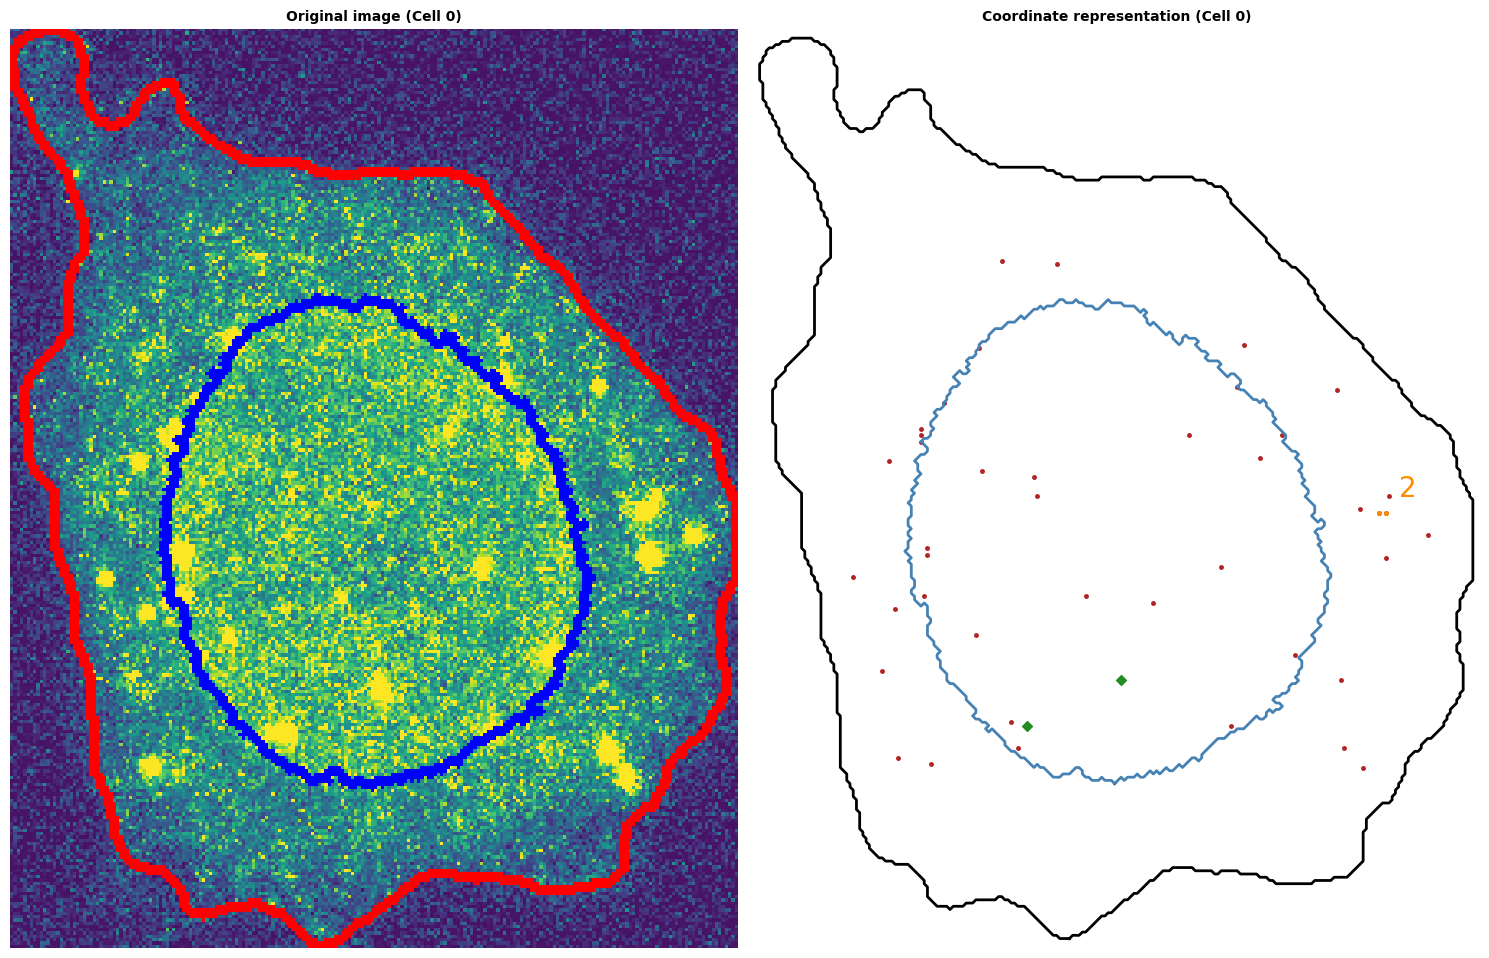

In [8]:
for i, cell_results in enumerate(fov_results):
    print("cell {0}".format(i))
    
    # get cell results
    cell_mask = cell_results["cell_mask"]
    cell_coord = cell_results["cell_coord"]
    nuc_mask = cell_results["nuc_mask"]
    nuc_coord = cell_results["nuc_coord"]
    rna_coord = cell_results["rna_coord"]
    foci_coord = cell_results["foci"]
    ts_coord = cell_results["transcription_site"]
    image_contrasted = cell_results["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))
    print("\r number of transcription sites {0}".format(len(ts_coord)))
    
    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, nuc_coord=nuc_coord, 
        rna_coord=rna_coord, foci_coord=foci_coord, other_coord=ts_coord, 
        image=image_contrasted, cell_mask=cell_mask, nuc_mask=nuc_mask, 
        title="Cell {0}".format(i))

#### (IPQDA: Table 1 - Extract cell information)

In [9]:
df = multistack.summarize_extraction_results(fov_results, ndim=3)
print("shape: {0}".format(df.shape))
df.head()

shape: (1, 8)


,cell_id,cell_area,nuc_area,nb_rna,nb_rna_in_nuc,nb_rna_out_nuc,nb_foci,nb_transcription_site
0,1,40652,14371,42,17,25,1,2


## Save cell-level results

To save the results obtained at the cell-level, two methods are possible:
- Save each element in a separate file (masks in a tif file, coordinates arrays in a npy or csv file and images in png file).
- Save everything in a **single npz file** (format specific to numpy), assigning each element with a keyword. Functions `bigfish.stack.save_cell_extracted` and `bigfish.stack.read_cell_extracted` can be used for this purpose.

In [10]:
for i, cell_results in enumerate(fov_results):
    # save results
    path = os.path.join(path_output, "results_cell_{0}.npz".format(i))
    stack.save_cell_extracted(cell_results, path)

In [11]:
# read results for the first cell of the FoV
path = os.path.join(path_output, "results_cell_0.npz")
cell_results = stack.read_cell_extracted(path, verbose=True)
print(cell_results["rna_coord"])

Available keys: cell_id, bbox, cell_coord, cell_mask, nuc_coord, nuc_mask, rna_coord, foci, transcription_site, image, dapi, smfish 

[[  0  69  91  -1]
 [  0 122 132  -1]
 [  0 129 154  -1]
 [  0 133  68  -1]
 [  0 135  84  -1]
 [  0 141  85  -1]
 [  0 145 185  -1]
 [  0 174 121  -1]
 [  0 195  37  -1]
 [  0 198 179  -1]
 [  0 211  77  -1]
 [  0 219  79  -1]
 [  1 172 100  -1]
 [  3  68  74  -1]
 [  6 146 191   0]
 [  9 153 206  -1]
 [  9 222  42  -1]
 [ 11 212 145  -1]
 [ 12  94 149  -1]
 [ 12  95  67  -1]
 [ 12 130  39  -1]
 [ 13 163 142  -1]
 [ 13 166  28  -1]
 [ 14 108 178  -1]
 [ 14 112  56  -1]
 [ 14 120  49  -1]
 [ 14 122 161  -1]
 [ 14 141 194  -1]
 [ 14 176  41  -1]
 [ 14 184  66  -1]
 [ 14 224  52  -1]
 [  0 157  51  -1]
 [  2 159  51  -1]
 [  1 124  49  -1]
 [  2 122  49  -1]
 [  2 172  50  -1]
 [  4 190 165  -1]
 [  6 146 193   0]
 [  7 107 147  -1]
 [  7 225 186  -1]
 [  9 160 193  -1]
 [  8 219 180  -1]]
